# 0.0. IMPORTS

In [77]:
import math
import inflection
import datetime
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from IPython.core.display import HTML
from IPython.display      import Image
from tabulate             import tabulate
from scipy                import stats as ss

## 0.1. Helper Functions

In [115]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2/n) / ( min( kcorr-1, rcorr-1 ) ) )

## 0.2. Loading data

In [2]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False)
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False)

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

In [3]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [4]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore (x)

cols_new = list( map( snakecase, cols_old ) )

#rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [5]:
print( 'Number of Rows: {}'.format( df1.shape[0]))
print( 'Number of Cols: {}'.format( df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [6]:
df1['date'] = pd.to_datetime( df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [7]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [8]:
df1['competition_distance'].max()

75860.0

In [9]:
# competition_distance              2642
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )


# competition_open_since_month    323348
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )


# competition_open_since_year     323348
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )


# promo2_since_week               508031
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )


# promo2_since_year               508031
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )


# promo_interval                  508031
month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr',5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )



In [10]:
df1.sample(5).T

,353313,44459,716207,886106,760434
store,69,975,48,467,790
day_of_week,4,1,5,7,1
date,2014-08-28 00:00:00,2015-06-22 00:00:00,2013-09-27 00:00:00,2013-04-28 00:00:00,2013-08-19 00:00:00
sales,7771,6654,4782,0,6937
customers,1018,630,519,0,751
open,1,1,1,0,1
promo,0,0,1,0,0
state_holiday,0,0,0,0,0
school_holiday,1,0,0,0,0
store_type,c,a,a,a,d


In [11]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types 

In [12]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
df1.dtypes


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [13]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes

In [14]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std - min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

#concatenate
m = pd.concat( [d2,d3,d4,ct1,ct2,d1,d5,d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/home/alexandre/.pyenv/versions/3.8.0/envs/DataScienceEmProducao/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

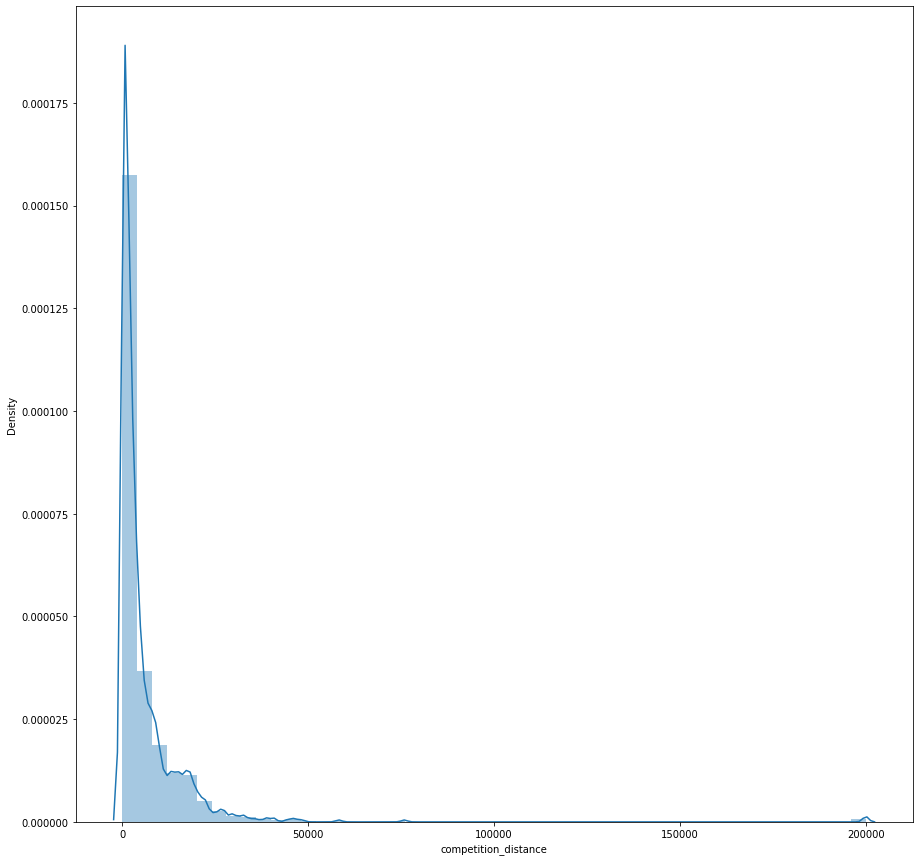

In [15]:
plt.rcParams['figure.figsize'] = [15, 15]
sns.distplot( df1['competition_distance'] )


In [16]:
cat_attributes.apply( lambda x: x.unique( ).shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

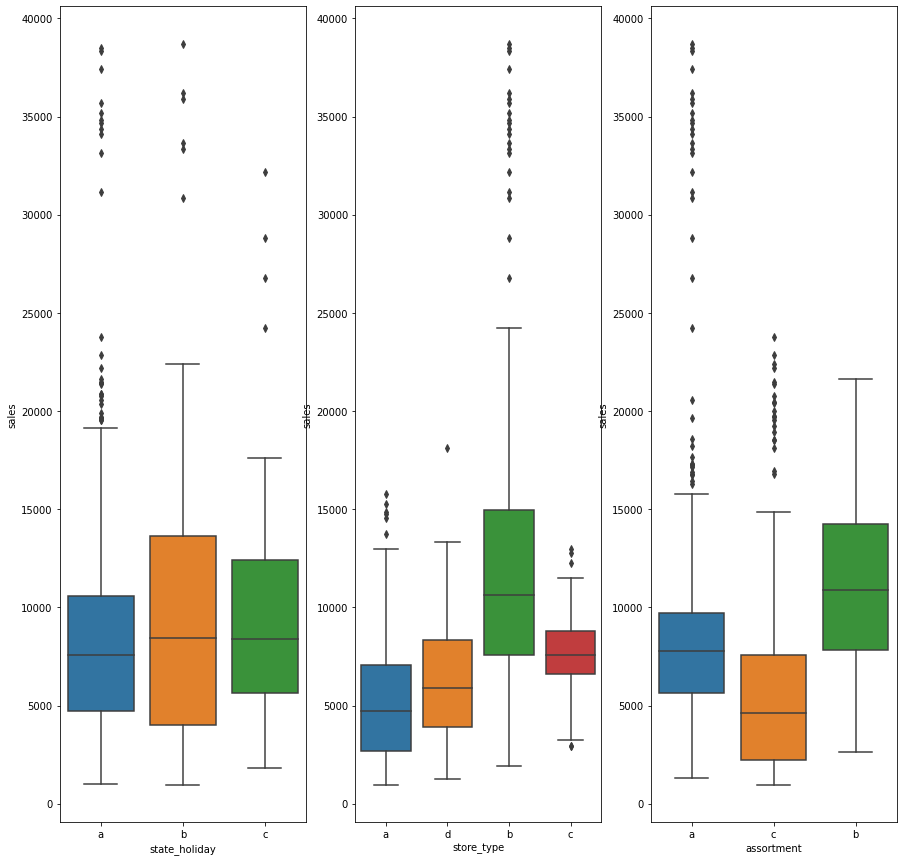

In [17]:
aux1 = df1[( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0)]

plt.subplot( 1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot( 1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot( 1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1 )


# 2.0. PASSO 02 - FEATURE ENGINEERING

In [18]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

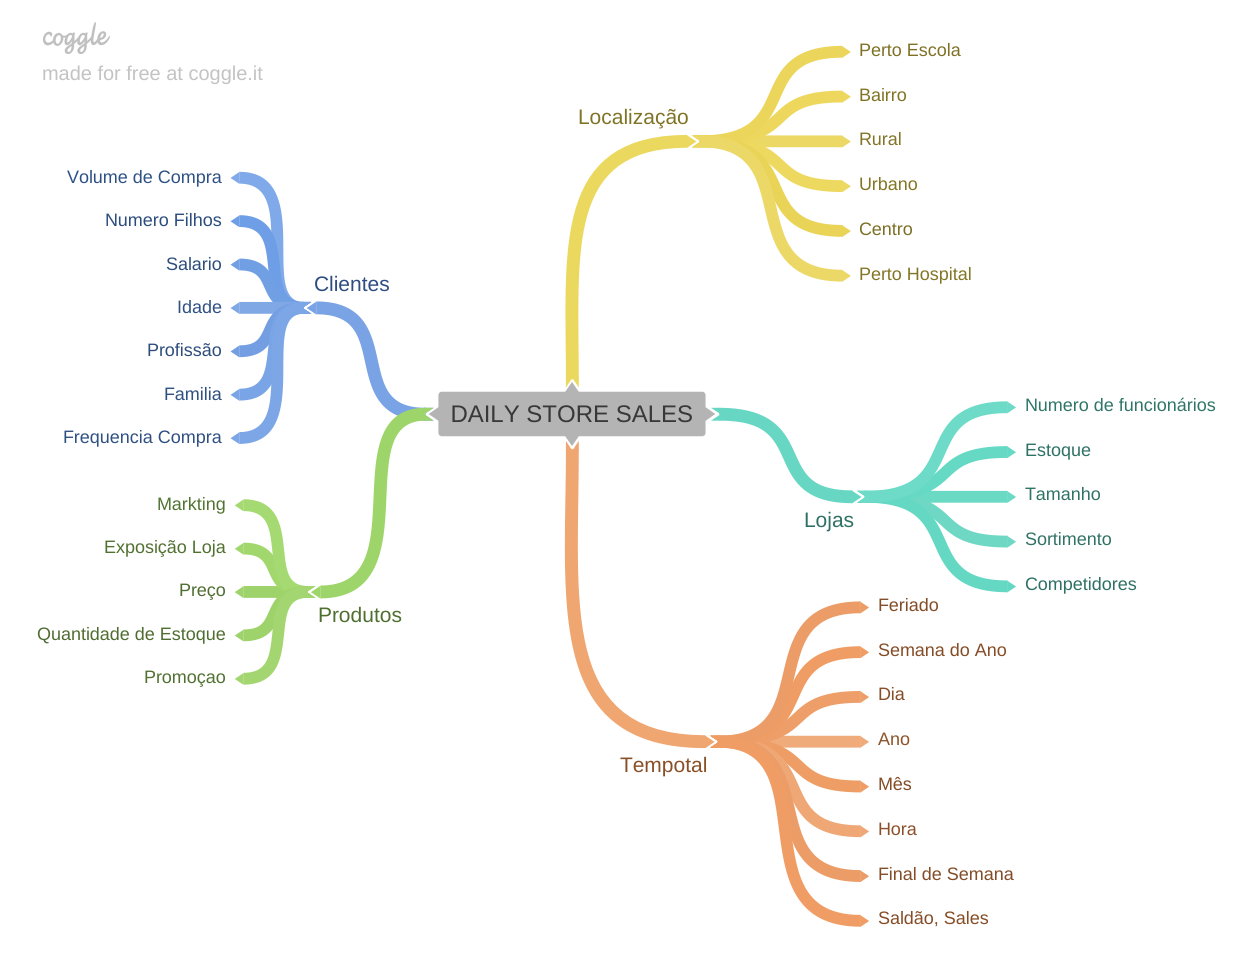

In [19]:
Image( 'img/MindMapHypothesis.png')

## 2.2. Criancao das Hipoteses   

### 2.2.1. Hipoteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de Estoque deveriam vender mais.

**3.** Lojas com maior Porte deveriam vender mais.

**4.** Lojas com maior Sortimento deveriam vender mais.

**5.** Lojas com competidores mais proximos deveriam vender menos.

**5.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.2.2. Hipoteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expoe mais os produtos na vitrine deveriam vender mais

**3.** Lojas que tem preços menores nos produtos deveriam vender mais

**4.** Lojas com promoções mais agrassivas (descontos maiores) deveriam vender mais

**5.** Lojas cLojas com promoções ativas por mais tempo

**6.** Lojas com mais dias de promoção deveriam vender mais

**7.** Lojas com mais promoções consecutivas deveriam vender mais

### 2.2.3  Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos

**3.** Lojas deveriam vender mais no segundo semestre dos anos

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês

**5.** Lojas deveriam vender menos aos finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.3. Lista Final de Hipoteses

**1.** Lojas com maior Sortimento deveriam vender mais.

**2.** Lojas com competidores mais proximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas Lojas com promoções ativas por mais tempo deveriam vender mais

**5.** Lojas com mais dias de promoção deveriam vender mais

**6.** Lojas com mais promoções consecutivas deveriam vender mais

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais

**8.** Lojas deveriam vender mais ao longo dos anos

**9.** Lojas deveriam vender mais no segundo semestre dos anos

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês

**11.** Lojas deveriam vender menos aos finais de semana

**12.** Lojas deveriam vender menos durante os feriados escolares

## 2.4. Feature Engineering

In [20]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of yaer
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')


# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 ) 
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( (df2['date'] - df2['promo_since'])/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'puplic_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christimas' if x == 'c' else 'regular_day' )

<ipython-input-20-9270c224f884>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [21]:
df2.head( ).T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [22]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [23]:
df3 = df3[(df3['open'] !=0) & (df3['sales'] > 0)]

## 3.2. Selecao das Colunas

In [24]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [25]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# 4.0. PASSO 04 - ANALISE EXPLORATORIA DE DADOS

In [26]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

/home/alexandre/.pyenv/versions/3.8.0/envs/DataScienceEmProducao/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales'>

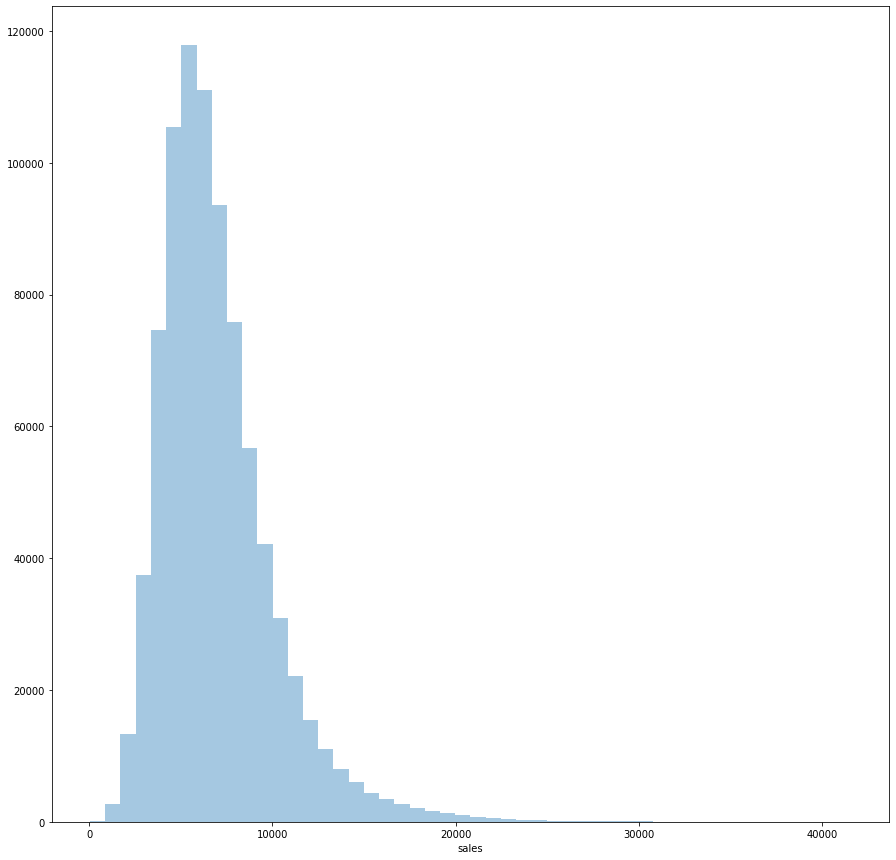

In [27]:
sns.distplot( df4['sales'], kde=False )

### 4.1.2. Numerical Variable

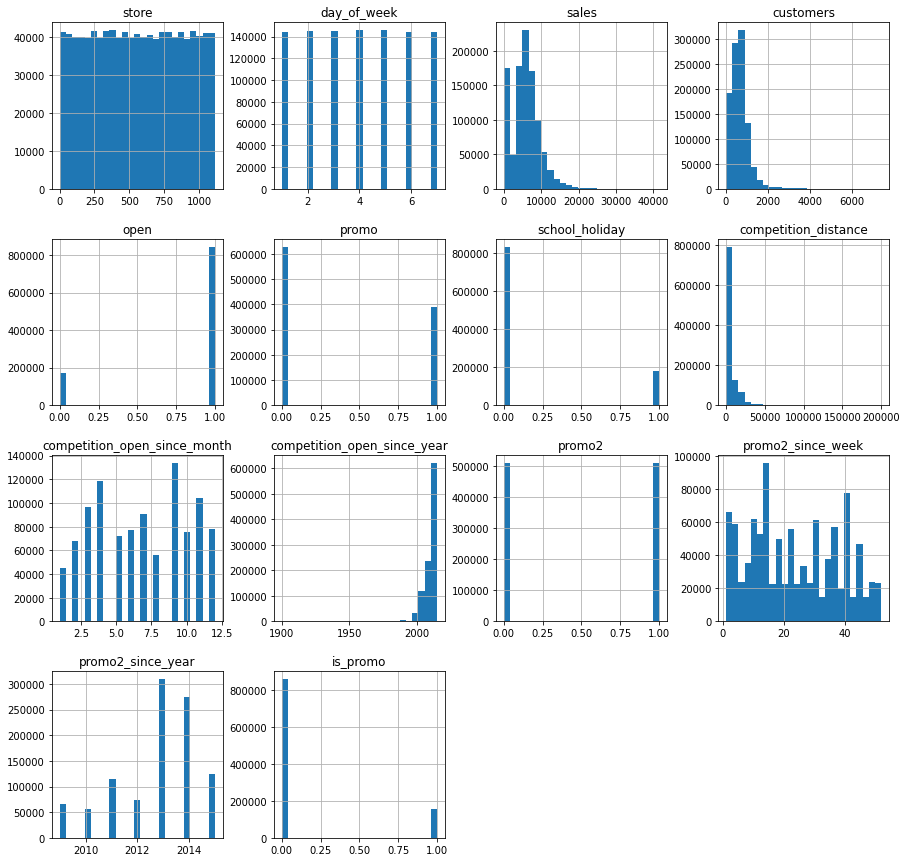

In [28]:
num_attributes.hist( bins=25 );

### 4.1.3. Categorical Variable

/home/alexandre/.pyenv/versions/3.8.0/envs/DataScienceEmProducao/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alexandre/.pyenv/versions/3.8.0/envs/DataScienceEmProducao/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alexandre/.pyenv/versions/3.8.0/envs/DataScienceEmProducao/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, 

<AxesSubplot:xlabel='sales', ylabel='Density'>

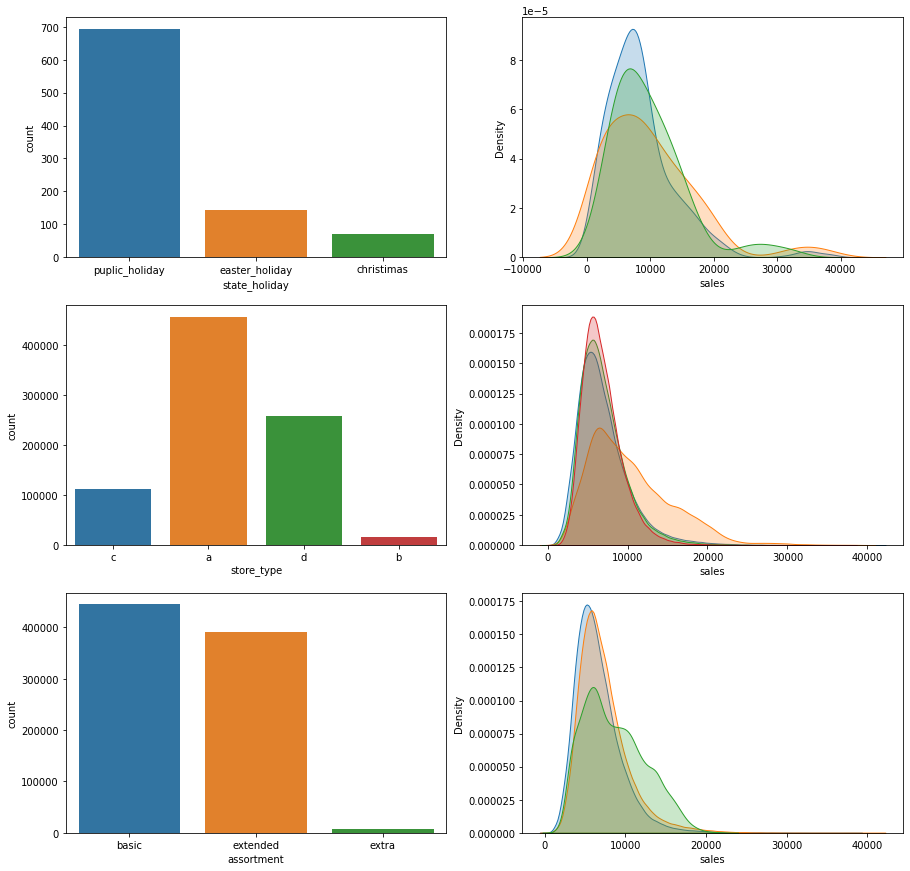

In [29]:
# state_holiday
plt.subplot( 3,2,1)
a= df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3,2,2)
sns.kdeplot( df4[df4['state_holiday'] == 'puplic_holiday']['sales'], label='puplic_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christimas']['sales'], label='christimas', shade=True )

# store_type
plt.subplot( 3,2,3)
sns.countplot( df4['store_type'] )
plt.subplot( 3,2,4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3,2,5)
sns.countplot( df4['assortment'] )
plt.subplot( 3,2,6)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )



## 4.2. Analise Bivariada

### 4.2.0 Validação das Hipoteses

#### H1. Lojas com maior Sortimento deveriam vender mais.
**FALSA** Lojas com MAIOR ASSORTMENT vendem MENOS

<AxesSubplot:xlabel='year_week'>

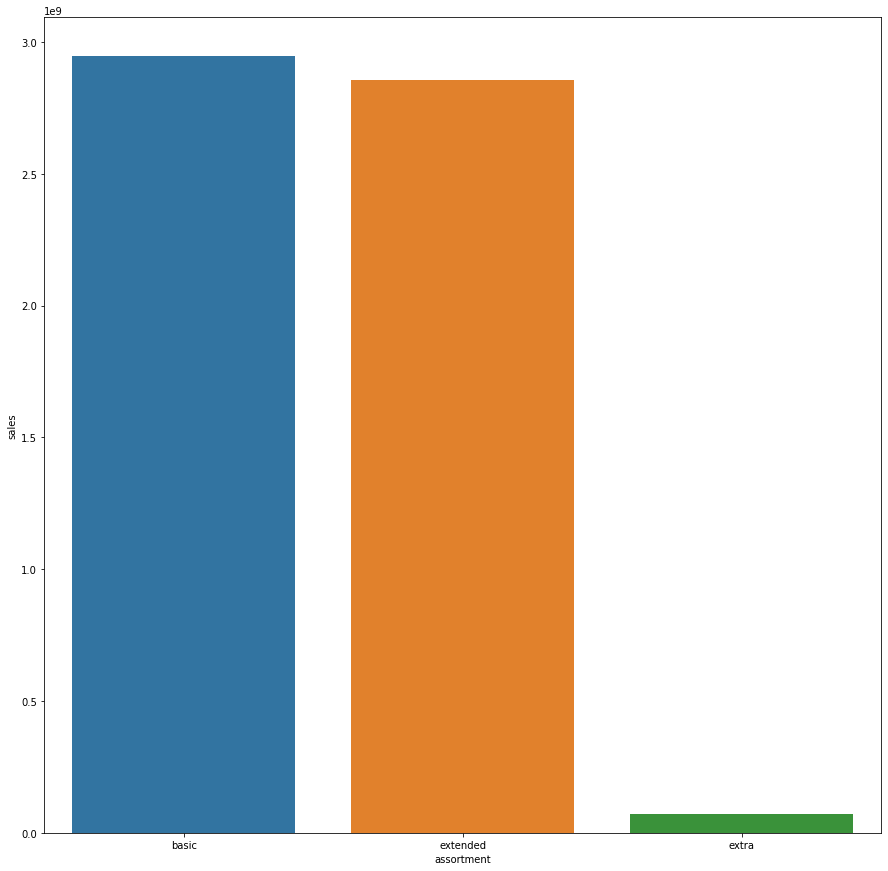

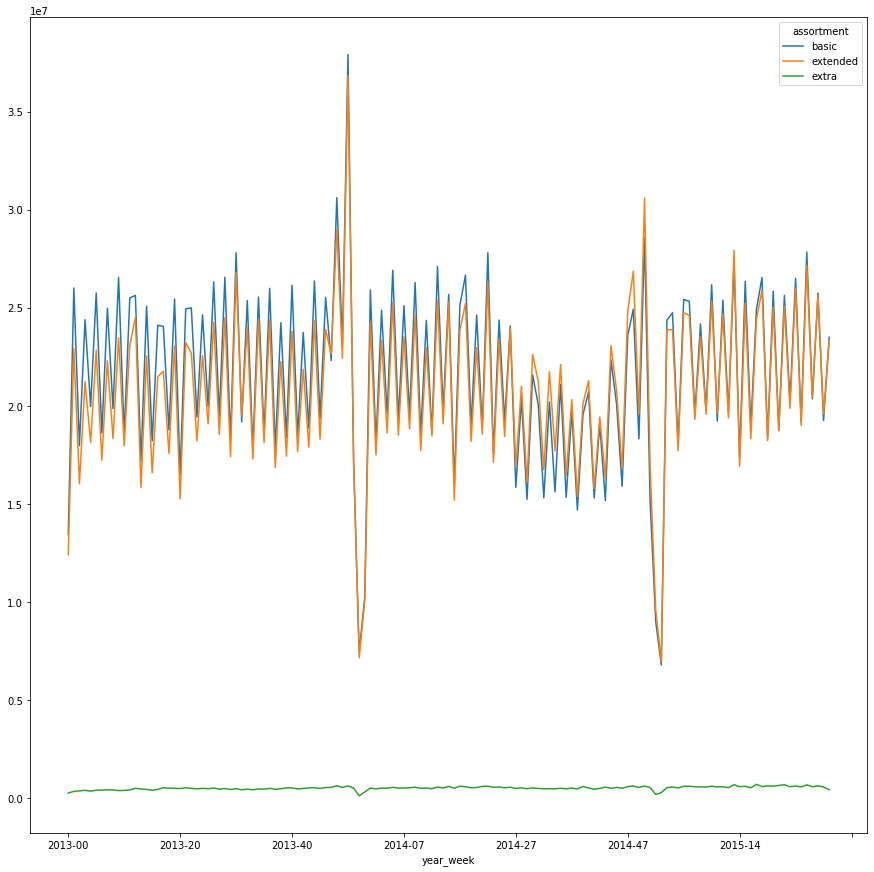

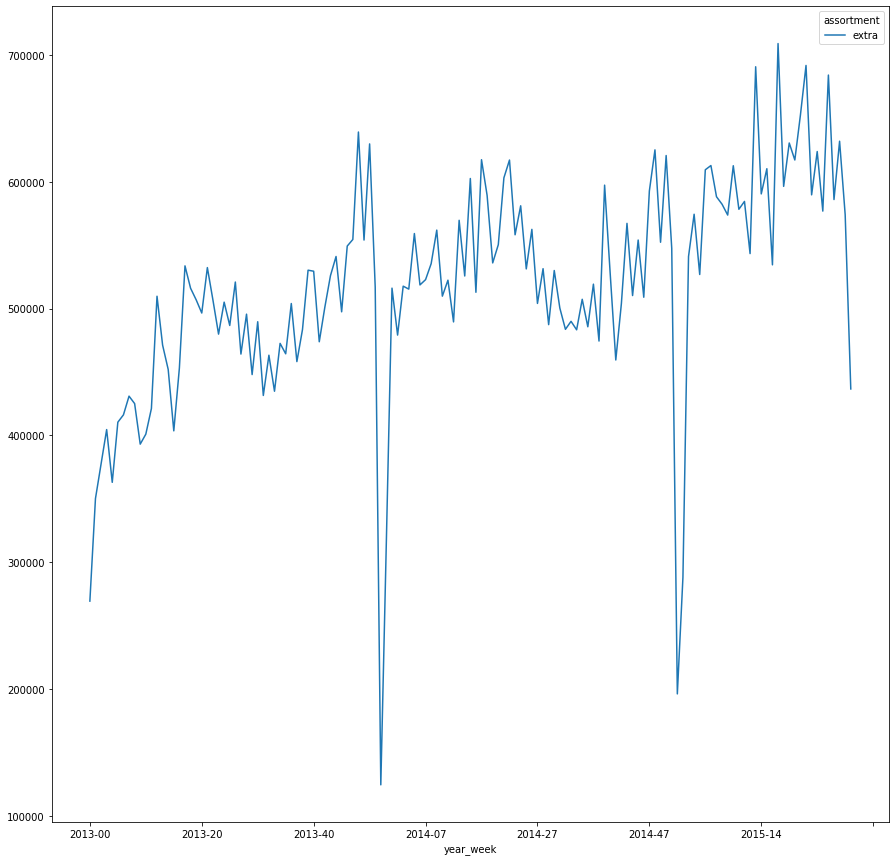

In [30]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment').sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

In [31]:
aux2.head()

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693


#### H2. Lojas com competidores mais proximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PROXIMOS vendem MENOS.

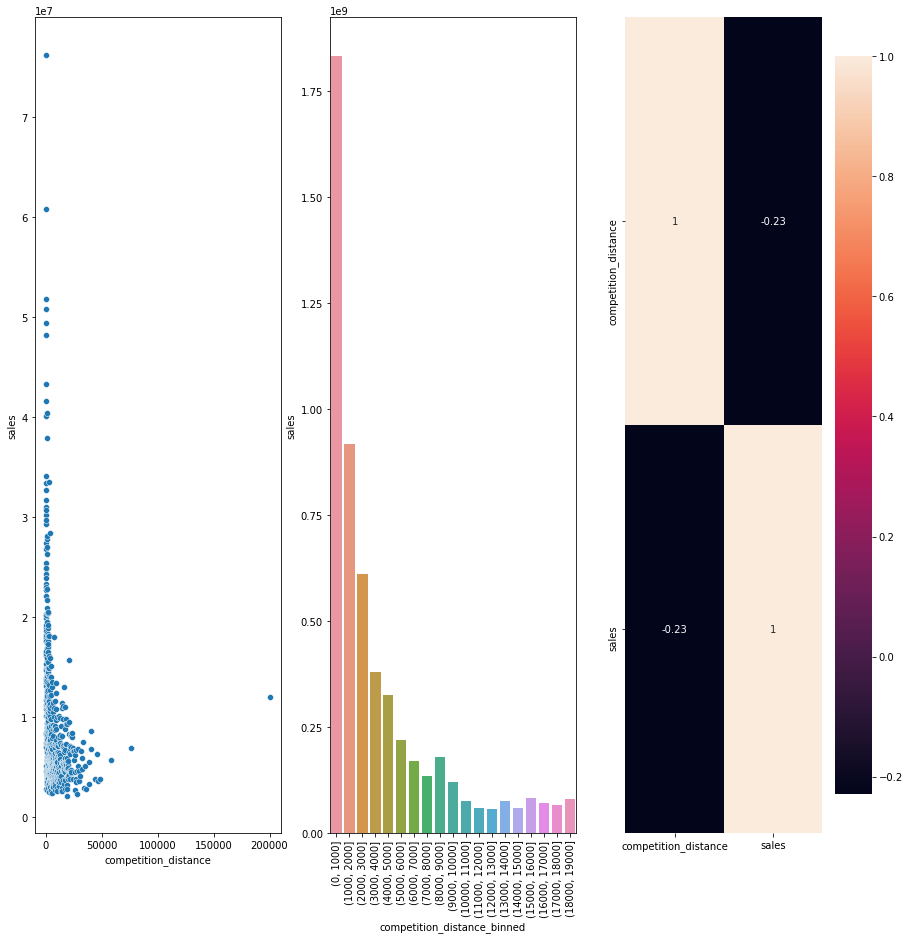

In [32]:
aux1 = df4[['competition_distance', 'sales']].groupby ( 'competition_distance').sum().reset_index()

plt.subplot( 1, 3, 1)
sns.scatterplot( x = 'competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2)
bins = list( np.arange( 0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 )

plt.subplot( 1, 3, 3)
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );

In [33]:
aux1.sample(4)

,competition_distance,sales,competition_distance_binned
625,26450.0,4519416,NaN
531,13990.0,4075915,"(13000.0, 14000.0]"
1,30.0,17552666,"(0.0, 1000.0]"
357,5260.0,5229014,"(5000.0, 6000.0]"


#### H3. Lojas com competidores a mais tempo deveriam vender mais.
**FALSA** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

In [34]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

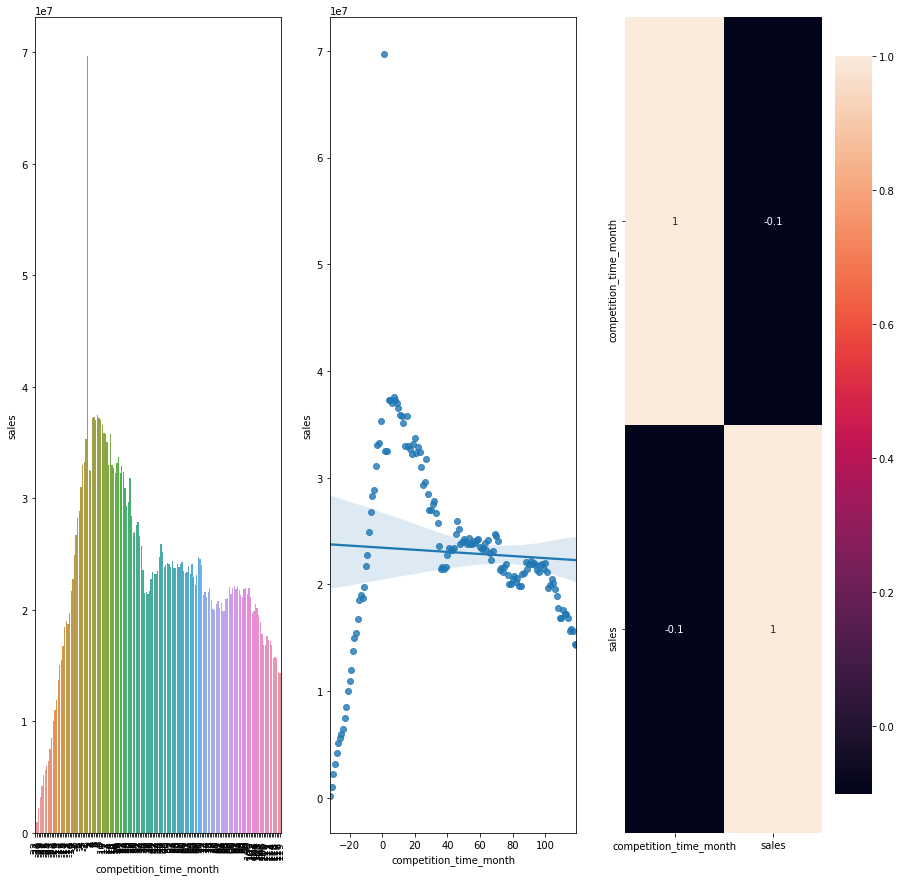

In [35]:
plt.subplot( 1, 3, 1)
aux1 = df4[['competition_time_month','sales']].groupby( 'competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0)]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2)
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3)
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );




#### **H4.** Lojas Lojas com promoções ativas por mais tempo deveriam vender mais
**FALSA** Lojas com PROMOCOES ATIVAS POR MAIS TEMPO VENDEM MENOS, depois de um certo periodo de promocao

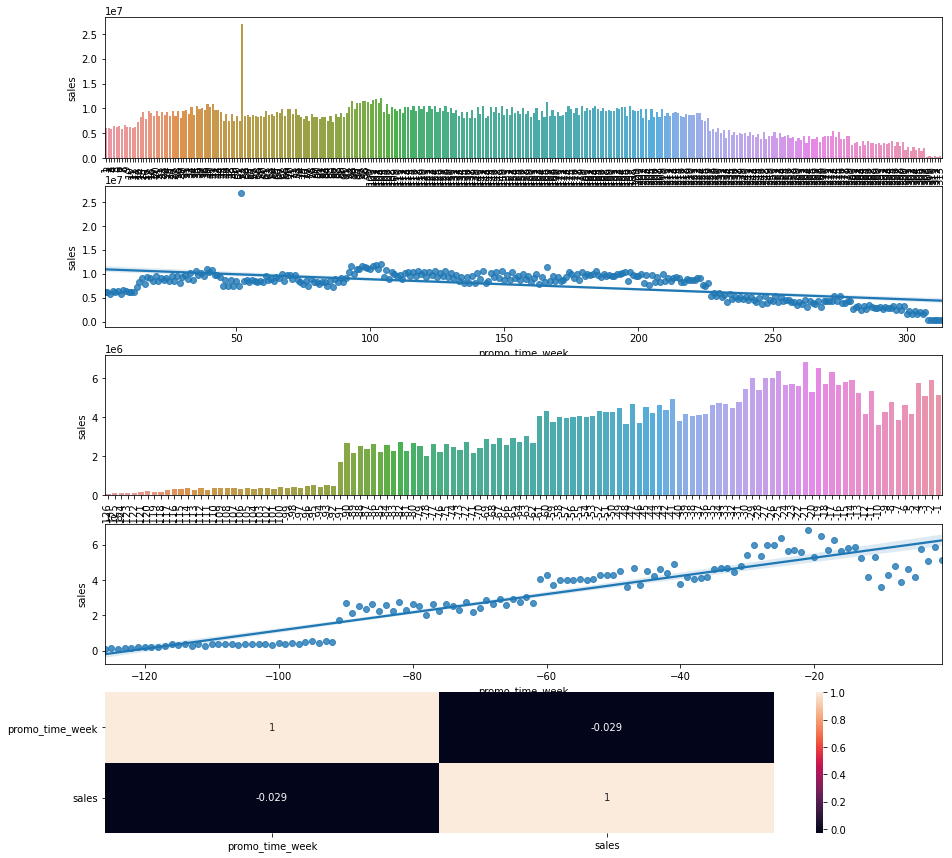

In [36]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()
# sns.barplot( x='promo_time_week', y='sales', data=aux1 );


plt.subplot( 5, 1, 1 )
aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 5, 1, 2 )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( 5, 1, 3 )
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( 5, 1, 4 )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( 5, 1, 5 )
sns.heatmap( aux1.corr( method='pearson'), annot=True);

#### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais<s>


#### **H6.** Lojas com mais promocoes consecutivas deveriam vender mais.
**FALSA** Lojas com COM MAIS PROMOCOES CONSECUTIVAS vendem MENOS

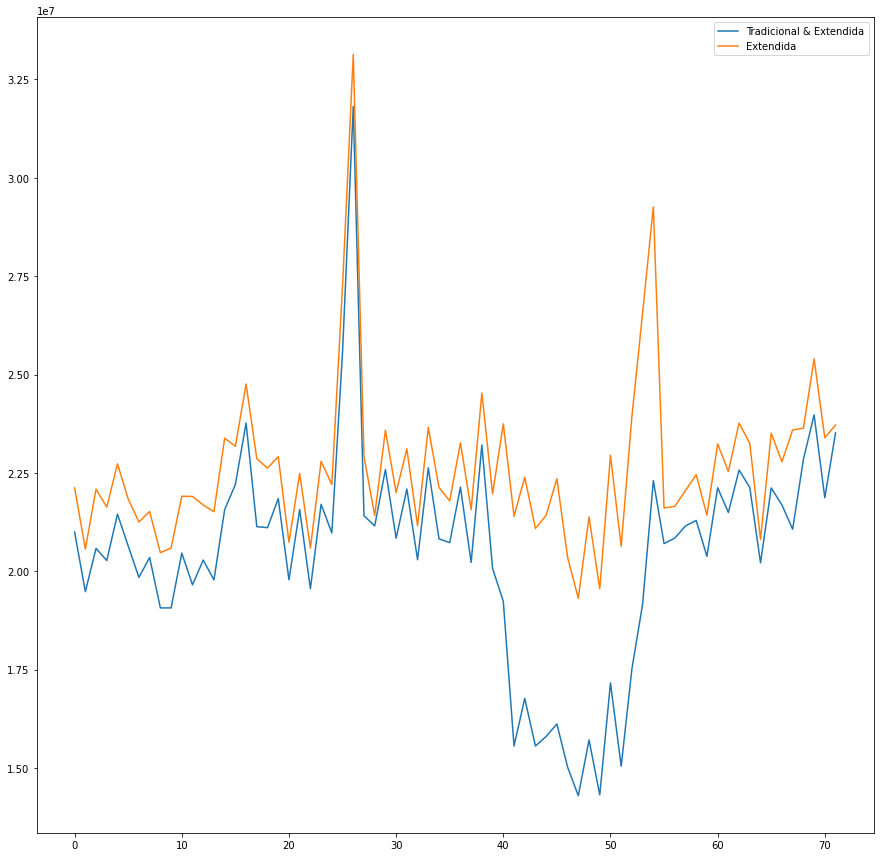

In [37]:
df4[['promo','promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby ( 'year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby ( 'year_week').sum().reset_index()
aux2.plot( ax=ax )


ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

#### H7. Lojas abertas durante o feriado de Natal deveriam vender mais
**FALSA** Lojas abertas durante o feriado de Natal vendem MENOS

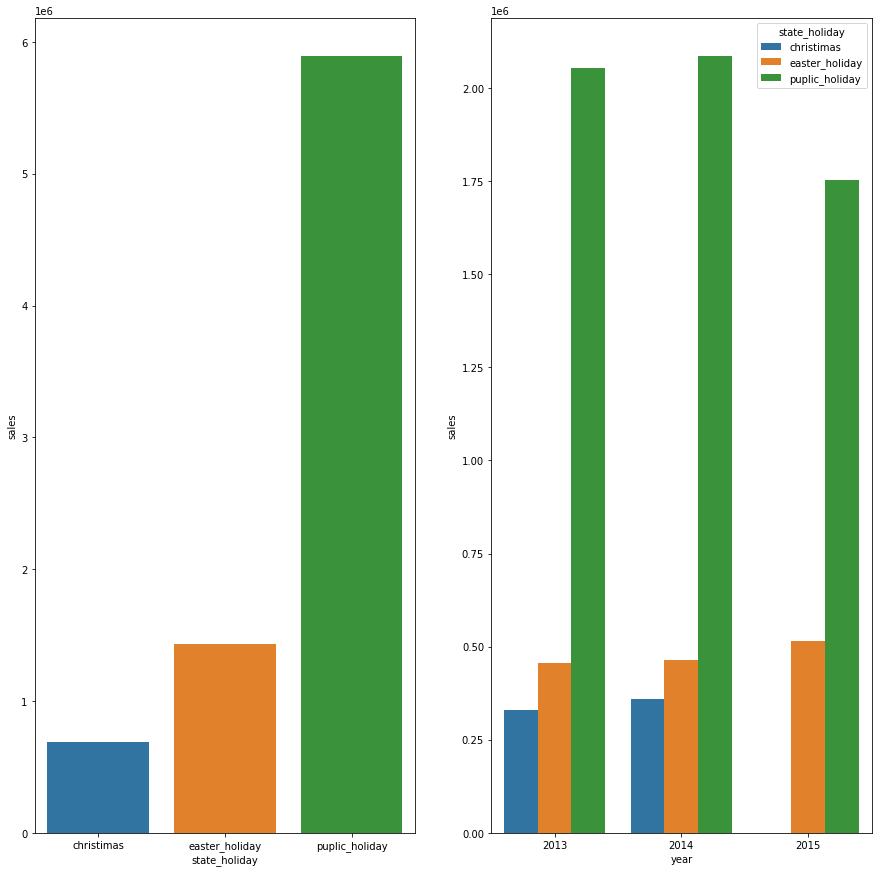

In [38]:
# plt.figure( figsize=( 15, 7))
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday').sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2  );

#### H8. Lojas deveriam vender mais ao longo dos anos
**FALSA** Lojas vendem MENOS ao londo dos anos

<AxesSubplot:>

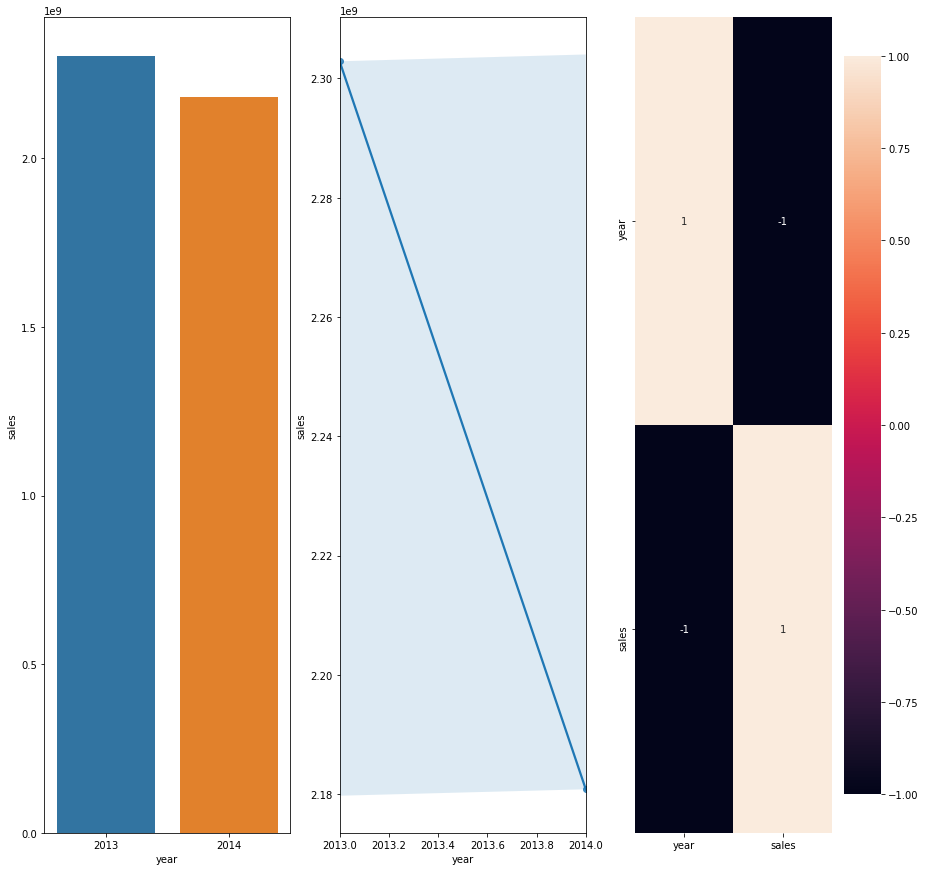

In [39]:
plt.subplot(1, 3, 1)
aux1 = df4[df4['year'] !=2015][['year', 'sales']].groupby( 'year').sum().reset_index()
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot(1, 3, 2)
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True)


#### H9. Lojas deveriam vender mais no segundo semestre dos anos
**FALSA** Lojas vendem MENOS no segundo semestre do ano


<AxesSubplot:>

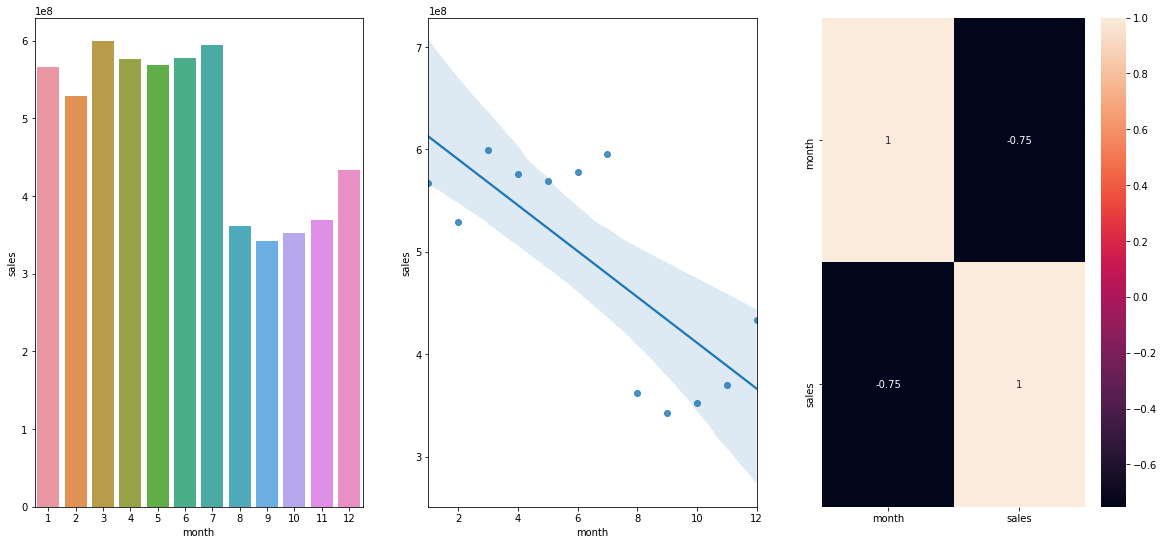

In [40]:
plt.figure(figsize = (20, 9))

plt.subplot(1, 3, 1)
aux1 = df4[['month', 'sales']].groupby( 'month').sum().reset_index()
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot(1, 3, 2)
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True)

#### H10. Lojas deveriam vender mais depois do dia 10 de cada mês
**VERDADEIRA** Lojas VENDEM MAIS depois do dia 10 de cada mês


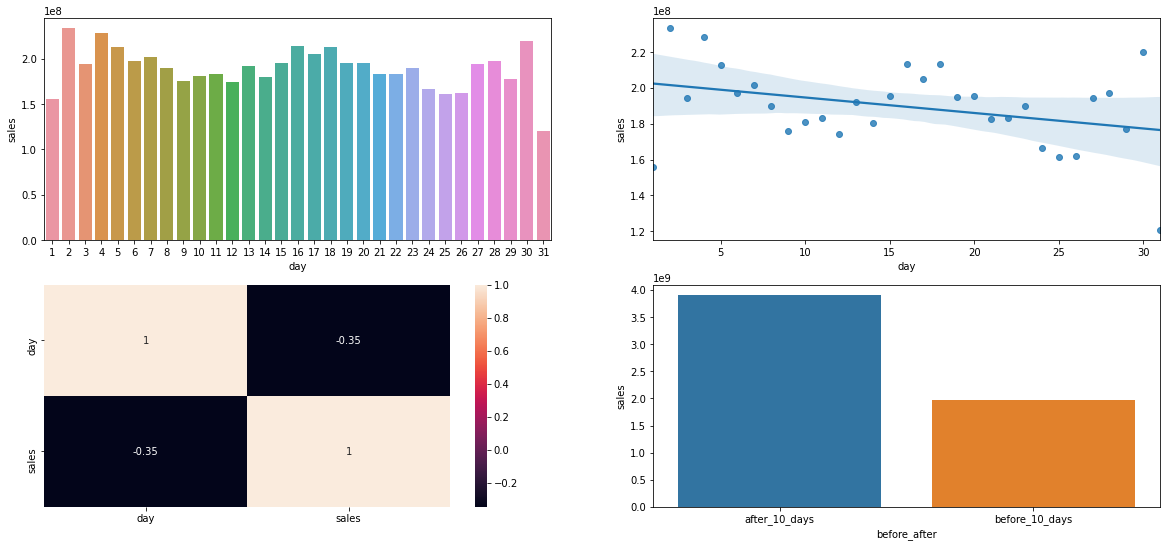

In [47]:
plt.figure(figsize = (20, 9))

plt.subplot(2, 2, 1)
aux1 = df4[['day', 'sales']].groupby( 'day').sum().reset_index()
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot(2, 2, 2)
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot(2, 2, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True)

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )

aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot( x='before_after', y='sales', data=aux2 );

#### H11. Lojas deveriam vender menos aos finais de semana
**VERDADEIRA** Lojas VENDEM MENOS nos finais de semana

<AxesSubplot:>

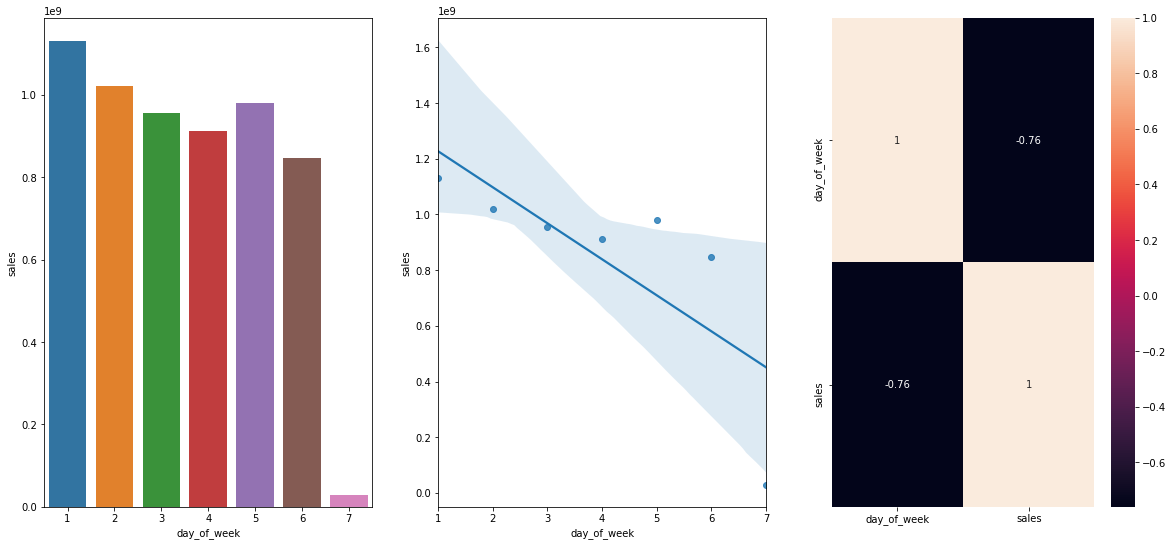

In [48]:
plt.figure(figsize = (20, 9))

plt.subplot(1, 3, 1)
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week').sum().reset_index()
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot(1, 3, 2)
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True)

#### H12. Lojas deveriam vender menos durante os feriados escolares
**VERDADERA** lojas vendem MENOS nos feriados escolares, exceto o meses de Julho e Agosto

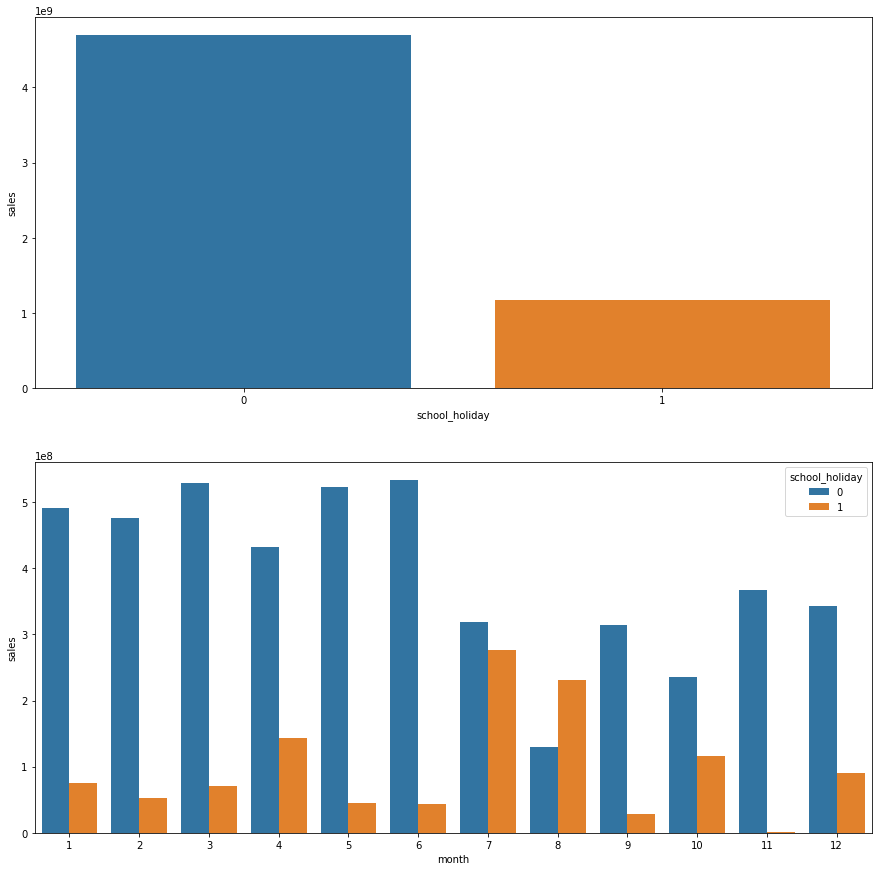

In [51]:
plt.subplot( 2, 1, 1)
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday').sum().reset_index()
sns.barplot( x='school_holiday', y='sales', data=aux1 );

plt.subplot( 2, 1, 2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()
sns.barplot( x='month', y='sales', hue='school_holiday',  data=aux2 );

### 4.2.1 Resumo das Hipoteses

In [55]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Media'],
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Media'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Baixa'],]

print( tabulate( tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. Analise Multivariada

### 4.3.1. Numerical Atributes

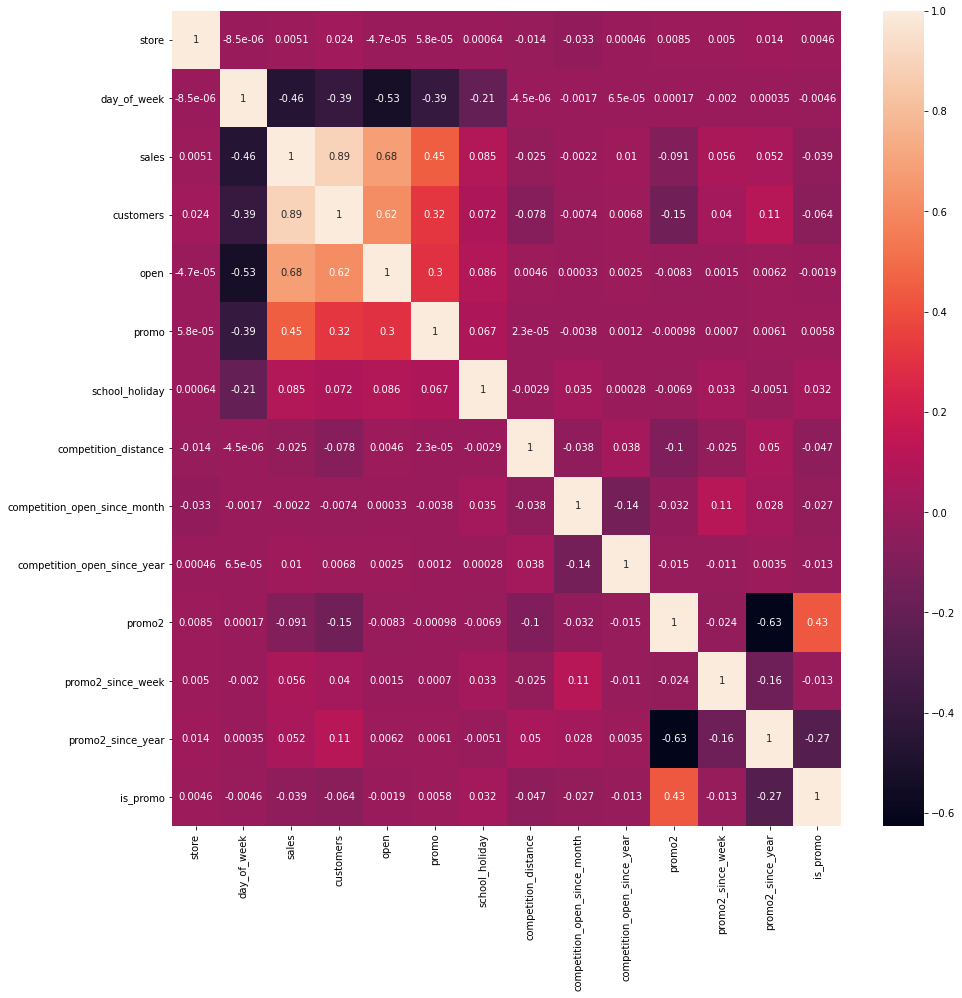

In [66]:
correlation = num_attributes.corr( method='pearson')
sns.heatmap( correlation, annot=True );

### 4.3.2. Categorical Atributes

In [103]:
a = df4.select_dtypes( include='object' )

In [116]:
a1 = cramer_v( a['state_holiday'], a['state_holiday'])
a2 = cramer_v( a['state_holiday'], a['store_type'])
a3 = cramer_v( a['state_holiday'], a['assortment'])

a4 = cramer_v( a['store_type'], a['state_holiday'])
a5 = cramer_v( a['store_type'], a['store_type'])
a6 = cramer_v( a['store_type'], a['assortment'])

a7 = cramer_v( a['assortment'], a['state_holiday'])
a8 = cramer_v( a['assortment'], a['store_type'])
a9 = cramer_v( a['assortment'], a['assortment'])

d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})

d = d.set_index( d.columns )


<AxesSubplot:>

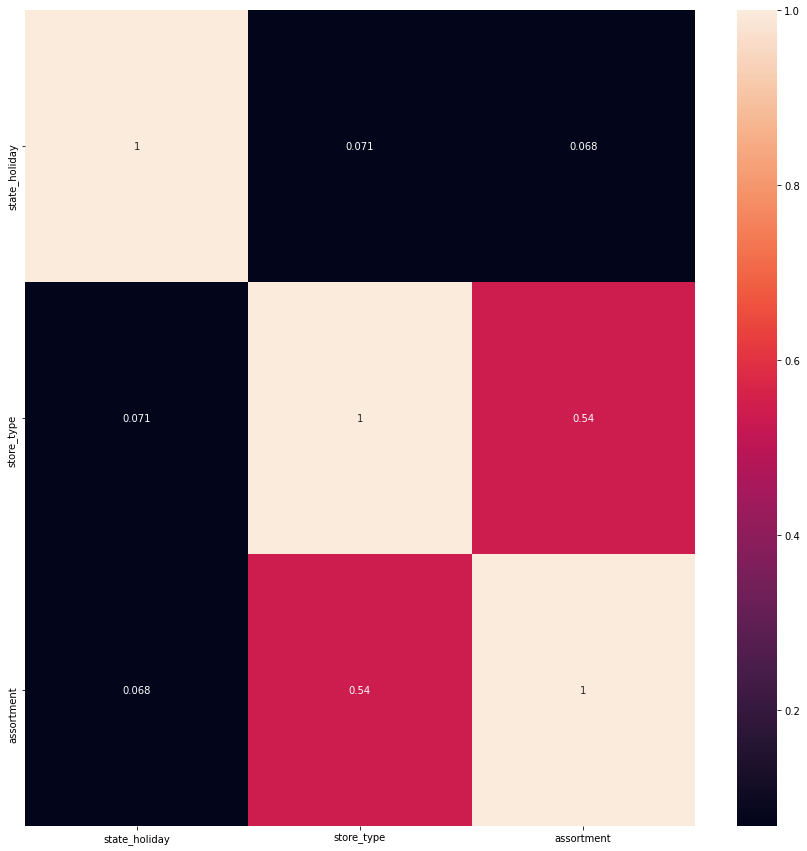

In [117]:
sns.heatmap( d, annot=True )